In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('./modified_medsam_repo')

In [2]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_scores/class_Unknown' not in dicto.keys() or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'val_dice_score', 'num_samples_per_epoch']]

    #assert ret_df.shape[0] == 102
    assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [36]:
#multitask, no prompt
#multitask_unprompt = pd.DataFrame(multitask_unprompt)
#multitask_unprompt = multitask_unprompt.iloc[1:, :].reset_index(names='label_number')

In [39]:
for k in multitask_unprompt.keys():
    print(k)
    print(len(multitask_unprompt[k]))

dice_sensitivity
103
dice_specificity
103
overall_dice
103
label_numbers
103


In [41]:
multitask_unprompt = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_multitask_unprompted_test_label1.pkl')
multitask_unprompt['label_numbers'] = list(range(0,103))
multitask_unprompt = pd.DataFrame(multitask_unprompt).loc[1:, :].reset_index(drop=True)

,dice_sensitivity,dice_specificity,overall_dice,label_numbers
0,8.013906e-01,0.995420,0.913209,1
1,7.798378e-01,0.998572,0.973925,2
2,1.315103e-07,1.000000,0.947565,3
3,5.822296e-01,0.997506,0.927913,4
4,7.921169e-01,0.996916,0.948685,5
...,...,...,...,...
97,5.706789e-01,0.994869,0.899405,98
98,5.985841e-01,0.994546,0.910256,99
99,5.824413e-01,0.996364,0.926969,100
100,5.240251e-01,0.993644,0.963483,101


In [4]:
def proc_pattern_for_eval_result_load(pattern):
    files = glob(pattern)
    listo = []
    for file in files:
        label_num = int(file.split('/')[-1].split('label')[1].split('.pkl')[0])
        
        stuff = pd.read_pickle(file)
        this_list = [label_num, stuff['dice_sensitivity'].item(), stuff['dice_specificity'].item(), stuff['overall_dice'].item()]
        this_arr = np.array(this_list).reshape((1, 4))
        listo.append(this_arr)

        

    combined = np.concatenate(listo, axis = 0)
    df = pd.DataFrame(combined, columns = ['label_number', 'dice_sensitivity', 'dice_specificity', 'overall_dice'])
    df = df.sort_values('label_number').reset_index(drop=True)

    return df

#yolov7s
yolov7 = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_singletask_yolov7_prompted_val_label*.pkl')
yolov7_longer = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_singletask_yolov7_longer_prompted_val_label*.pkl')

#pooled
listo = []
for node in range(8):
    xx = pd.read_pickle(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_pooltask_yolov7_prompted_val_label1_node{node}.pkl')
    for k in xx.keys():
        xx[k] = xx[k].flatten()
    dfo = pd.DataFrame.from_dict(xx)
    listo.append(dfo)
pooled = pd.concat(listo)
pooled = pooled.rename(mapper = {'label_numbers':'label_number'}, axis = 'columns')
pooled = pooled.groupby('label_number').agg({'dice_sensitivity':'mean', 'dice_specificity':'mean', 'overall_dice':'mean'}).reset_index()

# multitask no prompt
multitask_unprompt = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_multitask_unprompted_test_label1.pkl')
multitask_unprompt['label_numbers'] = list(range(0,103))
multitask_unprompt = pd.DataFrame(multitask_unprompt).loc[1:, :].reset_index(drop=True)

#multitask
multitask = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_multitask_unprompted_val_label1.pkl')
multitask = pd.DataFrame(multitask)
multitask = multitask.iloc[1:, :].reset_index(names='label_number')

#yolov7 pooled 3D
dices_3d = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_3D_pooled_labels_9-4-23/val_dices.npy')
dices_3d = dices_3d[1:].tolist()
label_numbers = list(range(1,103))
pooled_3d = pd.DataFrame({'label_number': label_numbers, 'dice_sensitivity': dices_3d})

# singletask no boxes
constant_bbox_finetune_df = read_tag_from_wandb(tag = 'constant_bbox', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox')

# singletask unet
singletask_unet = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_val_7-13-24/combined_val.pkl')
singletask_unet = pd.DataFrame(singletask_unet)
#singletask_unet = multitask.iloc[1:, :].reset_index(names='label_number')

# singletask medsam
singletask_medsam = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/singletask_medsam_eval_8-12-24/combined_val.pkl')
singletask_medsam = pd.DataFrame(singletask_medsam)



In [8]:
#print(multitask_unprompt['dice_sensitivity'].median())
print(multitask['dice_sensitivity'].median()) # this is an unprompted multitask
print(yolov7['dice_sensitivity'].median())
print(yolov7_longer['dice_sensitivity'].median())
print(pooled['dice_sensitivity'].median())
print(pooled_3d['dice_sensitivity'].median())
print(singletask_unet['dice_sensitivity'].median())
print(singletask_medsam['dice_sensitivity'].median())

0.5923540592193604
0.6594351828098297
0.7056998014450073
0.7047540545463562
0.7113972306251526
0.7089871764183044
0.6280268430709839


In [13]:
df_merged = multitask[['label_number', 'dice_sensitivity']].merge(yolov7[['label_number', 'dice_sensitivity']], 
                on='label_number', suffixes = ['_multitask', '_yolov7'], how='inner')

df_merged2 = yolov7_longer[['label_number', 'dice_sensitivity']].merge(pooled[['label_number', 'dice_sensitivity']], 
                on='label_number', suffixes = ['_yolov7_longer', '_pooled'], how='inner')
df_merged = df_merged.merge(df_merged2, on='label_number', how = 'inner')

pooled_3d = pooled_3d.rename(mapper = {'dice_sensitivity':'dice_sensitivity_pooled_3d'}, axis = 'columns')
df_merged = df_merged.merge(pooled_3d, on='label_number', how = 'inner')

singletask_unet = singletask_unet.rename(mapper = {'dice_sensitivity':'dice_sensitivity_singletask_unet', 'label_numbers':'label_number'}, axis='columns')
singletask_unet = singletask_unet[['label_number', 'dice_sensitivity_singletask_unet']]
df_merged = df_merged.merge(singletask_unet, on='label_number', how='inner')

df_merged

,label_number,dice_sensitivity_multitask,dice_sensitivity_yolov7,dice_sensitivity_yolov7_longer,dice_sensitivity_pooled,dice_sensitivity_pooled_3d,dice_sensitivity_singletask_unet
0,1,7.994661e-01,0.862020,0.885881,0.883167,0.886895,0.938193
1,2,7.696944e-01,0.811639,0.835924,0.820664,0.822044,0.875228
2,3,1.349329e-07,0.311646,0.354801,0.351988,0.363103,0.674957
3,4,5.743010e-01,0.599371,0.687716,0.677760,0.686748,0.708398
4,5,7.807698e-01,0.849339,0.860170,0.854176,0.854875,0.873651
...,...,...,...,...,...,...,...
97,98,5.675806e-01,0.667417,0.715483,0.713493,0.723542,0.715655
98,99,6.003175e-01,0.678250,0.738180,0.729847,0.741977,0.739795
99,100,5.792221e-01,0.685869,0.722563,0.719753,0.726841,0.722991
100,101,5.373104e-01,0.594538,0.650480,0.645915,0.657094,0.644095


In [14]:
merged_long = pd.melt(df_merged, id_vars = ['label_number'], 
                    value_vars = ['dice_sensitivity_multitask', 'dice_sensitivity_yolov7', 'dice_sensitivity_yolov7_longer', 
                    'dice_sensitivity_pooled', 'dice_sensitivity_pooled_3d', 'dice_sensitivity_singletask_unet'],
                    var_name = 'method', value_name = 'val_dice_score'
)
mapper = {'dice_sensitivity_pooled': 'pooled', 'dice_sensitivity_yolov7': 'yolov7',
          'dice_sensitivity_multitask': 'multitask', 'dice_sensitivity_yolov7_longer': 'yolov7_longer',
          'dice_sensitivity_pooled_3d': 'pooled_3D', 'dice_sensitivity_singletask_unet': 'singletask_unet'}
merged_long['method'] = merged_long['method'].map(mapper)

merged_long

,label_number,method,val_dice_score
0,1,multitask,7.994661e-01
1,2,multitask,7.696944e-01
2,3,multitask,1.349329e-07
3,4,multitask,5.743010e-01
4,5,multitask,7.807698e-01
...,...,...,...
607,98,singletask_unet,7.156550e-01
608,99,singletask_unet,7.397952e-01
609,100,singletask_unet,7.229909e-01
610,101,singletask_unet,6.440946e-01


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

multitask v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=1.426e-07 stat=-5.906e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=1.357e-08 stat=-6.418e+00
yolov7_longer v.s. pooled: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.419e-01


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x155459b56860>])

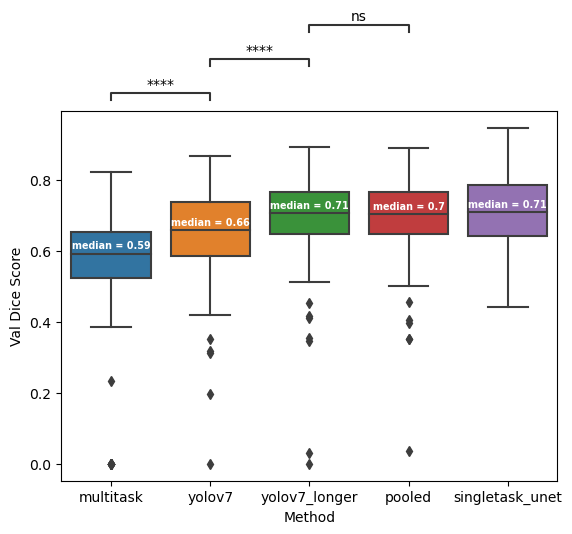

In [17]:
# is there significant difference in how well these methods perform?

order = ['multitask', 'yolov7', 'yolov7_longer', 'pooled', 'singletask_unet']
box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * merged_long['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1]),
        (order[1], order[2]),
        (order[2], order[3])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

multitask v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=1.902e-07 stat=-5.906e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=1.810e-08 stat=-6.418e+00
yolov7_longer v.s. pooled: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.419e-01
pooled v.s. pooled_3D: t-test paired samples with Bonferroni correction, P_val=1.702e-14 stat=-9.239e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x2aaab4c8b8e0>])

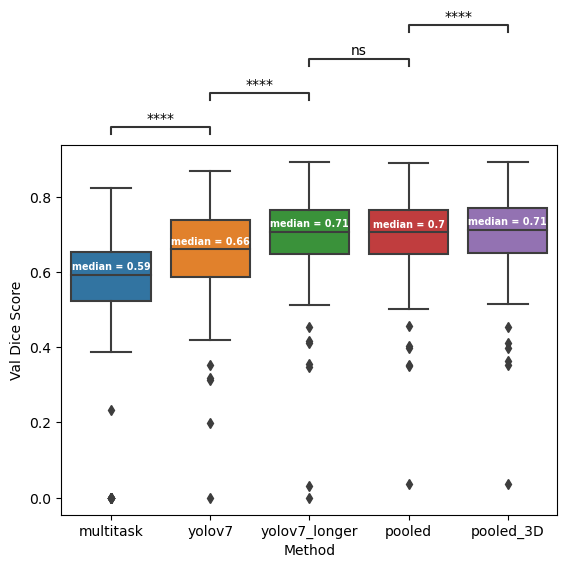

In [24]:
# including pooled 3d
# is there significant difference in how well these methods perform?

order = ['multitask', 'yolov7', 'yolov7_longer', 'pooled', 'pooled_3D']
box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * merged_long['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1]),
        (order[1], order[2]),
        (order[2], order[3]),
        (order[3], order[4])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


### 3D-pooled model performance

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pooled v.s. pooled_3D: t-test paired samples with Bonferroni correction, P_val=4.255e-15 stat=-9.239e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
 [<statannot.StatResult.StatResult at 0x2aab9e10ff70>])

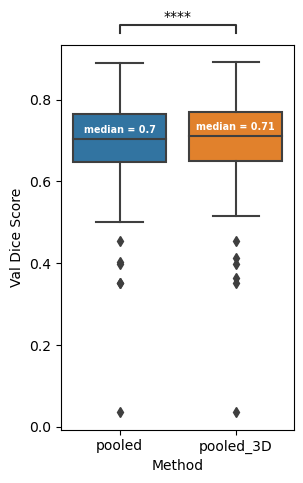

In [34]:
# pooled vs pooled-3D
# is there significant difference in how well these methods perform?

plt.figure(figsize=(3,5))
order = ['pooled', 'pooled_3D']
subset_df = merged_long[merged_long['method'].isin(order)].reset_index(drop=True)
box_plot = sns.boxplot(data = subset_df,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = subset_df.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * subset_df['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=subset_df,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


In [50]:
df_merged

,label_number,dice_sensitivity_multitask,dice_sensitivity_yolov7,dice_sensitivity_yolov7_longer,dice_sensitivity_pooled,dice_sensitivity_pooled_3d
0,1,7.994661e-01,0.862020,0.885881,0.883167,0.886895
1,2,7.696944e-01,0.811639,0.835924,0.820664,0.822044
2,3,1.349329e-07,0.311646,0.354801,0.351988,0.363103
3,4,5.743010e-01,0.599371,0.687716,0.677760,0.686748
4,5,7.807698e-01,0.849339,0.860170,0.854176,0.854875
...,...,...,...,...,...,...
97,98,5.675806e-01,0.667417,0.715483,0.713493,0.723542
98,99,6.003175e-01,0.678250,0.738180,0.729847,0.741977
99,100,5.792221e-01,0.685869,0.722563,0.719753,0.726841
100,101,5.373104e-01,0.594538,0.650480,0.645915,0.657094


Text(9.444444444444445, 0.5, 'Dice Score (Pooled 3D)')

<Figure size 500x500 with 0 Axes>

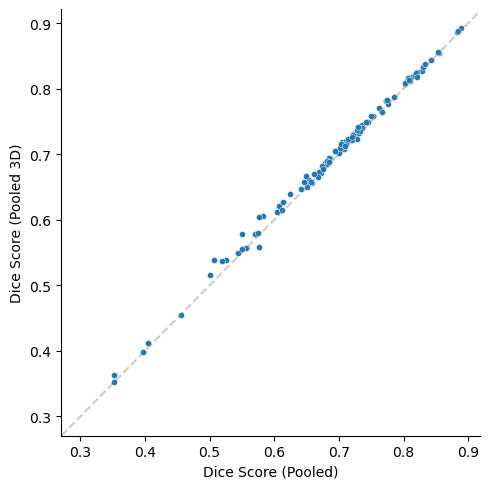

In [54]:
df_merged_tmp = df_merged[df_merged.dice_sensitivity_pooled > 0.2].reset_index(drop=True)
plt.figure(figsize=(5,5))
sns.relplot(df_merged_tmp, x = 'dice_sensitivity_pooled', y = 'dice_sensitivity_pooled_3d', s=20)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (Pooled)')
plt.ylabel('Dice Score (Pooled 3D)')

(102,)

### Singletask medsam vs unet

In [29]:
#dfo = pd.DataFrame(constant_bbox_finetune_df['val_dice_score'].tolist(), singletask_unet['dice_sensitivity_singletask_unet'].tolist())
dfo = pd.merge(constant_bbox_finetune_df['val_dice_score'], singletask_unet['dice_sensitivity_singletask_unet'],
    left_index=True, right_index=True)
dfo = dfo.rename(mapper={'val_dice_score': 'dice_sensitivity_singletask_medsam'}, axis='columns')
dfo

,dice_sensitivity_singletask_medsam,dice_sensitivity_singletask_unet
0,0.832331,0.938193
1,0.757189,0.875228
2,0.222655,0.674957
3,0.611897,0.708398
4,0.823429,0.873651
...,...,...
97,0.543173,0.715655
98,0.643358,0.739795
99,0.535619,0.722991
100,0.407994,0.644095


Text(9.444444444444445, 0.5, 'Dice Score (UNet)')

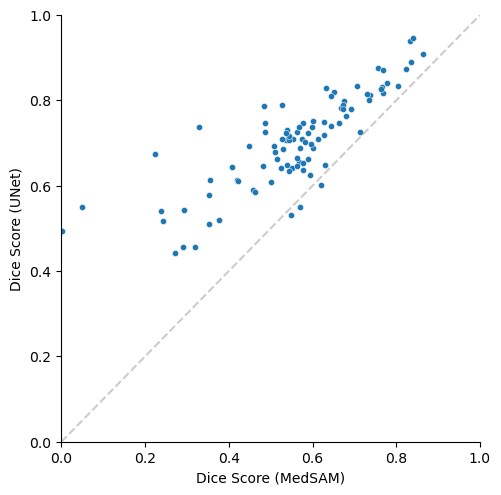

In [32]:
sns.relplot(dfo, x = 'dice_sensitivity_singletask_medsam', y = 'dice_sensitivity_singletask_unet', s=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (MedSAM)')
plt.ylabel('Dice Score (UNet)')

### Comparing learning rates of singletask unet on validation data

In [5]:
# lr 3.2e-5
singletask_unet_med = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_val_7-13-24/combined_val.pkl')
singletask_unet_med = pd.DataFrame(singletask_unet_med)

# lr 1e-4
singletask_unet_high = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_lr1e-4_val_7-30-24/combined_val.pkl')
singletask_unet_high = pd.DataFrame(singletask_unet_high)

# lr 1e-5
singletask_unet_low = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_lr1e-5_val_7-30-24/combined_val.pkl')
singletask_unet_low = pd.DataFrame(singletask_unet_low)

print(singletask_unet_med['dice_sensitivity'].median())
print(singletask_unet_med['dice_specificity'].median())
print(singletask_unet_med['dice_specificity'].min())

print(singletask_unet_high['dice_sensitivity'].median())
print(singletask_unet_high['dice_specificity'].median())
print(singletask_unet_med['dice_specificity'].min())

print(singletask_unet_low['dice_sensitivity'].median())
print(singletask_unet_low['dice_specificity'].median())
print(singletask_unet_med['dice_specificity'].min())

0.7089871764183044
0.9891116321086884
0.3603794276714325
0.7299074828624725
0.9889152348041534
0.3603794276714325
0.6627864241600037
0.9873768985271454
0.3603794276714325


In [15]:
(singletask_unet_med['dice_sensitivity'] - singletask_unet_high['dice_sensitivity']).max()

0.30725085735321045

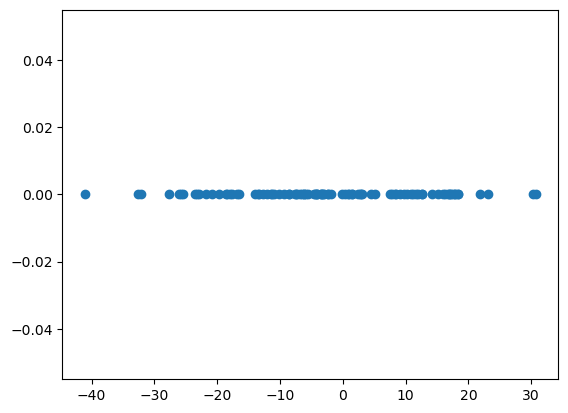

In [10]:
plt.scatter((singletask_unet_med['dice_sensitivity'] - singletask_unet_high['dice_sensitivity']) * 100, [0]*102)